# Boosting a decision stump
[Assignment](https://www.coursera.org/learn/ml-classification/supplement/3TYwk/boosting-a-decision-stump) of the Coursera opencousre [*Machine Learning: classification*](https://www.coursera.org/learn/ml-classification/home/welcome) week 5 on Boosting a classifier. 

# 1. Prepare the data

In [1]:
%matplotlib inline
from IPython.core.debugger import Pdb

In [2]:
import pandas as pd
import numpy as np
loans = pd.read_csv('../Data/lending-club-data.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Load data and apply one-hot encoding to change the categorical features into numeric ones

In [3]:
#  reassign the labels to have +1 for a safe loan, and -1 for a risky (bad) loan
loans['safe_loans'] = loans['bad_loans'].map({0: +1, 1: -1})
loans = loans.drop('bad_loans', axis=1)
# consider four features
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home_ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
target = 'safe_loans'
# extract these columns from the dataset and discard others
loans = loans[features + [target]]
# one hot encoding
loans = pd.get_dummies(loans)
loans.head(5)
# after encoding, we have new feature names
features = list(loans)
features.remove(target)

In [4]:
features

['grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'term_ 36 months',
 'term_ 60 months',
 'home_ownership_MORTGAGE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'emp_length_1 year',
 'emp_length_10+ years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_< 1 year',
 'emp_length_n/a']

## Balance the two classes in the dataset

In [5]:
# here we use the index provided by the lecturer
import json
train_idx_file = '../data/module-5-assignment-2-train-idx.json'
test_idx_file = '../data/module-5-assignment-2-test-idx.json'
with open(train_idx_file) as f:
    train_idx = json.load(f)
with open(test_idx_file) as f:
    test_idx = json.load(f)
train_data = loans.iloc[train_idx, :]
test_data = loans.iloc[test_idx, :]
print('train shape: ', train_data.shape, '. \nValue counts: \n', train_data['safe_loans'].value_counts())
print('test shape: ', test_data.shape, '. \nValue counts: \n', test_data['safe_loans'].value_counts())

train shape:  (37224, 26) . 
Value counts: 
  1    18748
-1    18476
Name: safe_loans, dtype: int64
test shape:  (9284, 26) . 
Value counts: 
 -1    4674
 1    4610
Name: safe_loans, dtype: int64


# 2. Weighted impurity metric definition

+ The basic principle to handle data point weight is to consider an example with weight $\alpha$ as $\alpha$ examples.
+ In this part, intead of error rate used in the course, we use the Gini Index as the impurity measure of a certain node. It is shown that Entropy or Gini Index is a better metric than classification error when choosing the splitting feature. Reason can be found [here](https://github.com/rasbt/python-machine-learning-book/blob/master/faq/decisiontree-error-vs-entropy.md).
+ For a binary decision tree, Gini Index for node t is defined as $GI(t)=1-p_{c1}^2-p_{c2}^2$, where $p_{c1}$ is the ratio of examples belonging to class $c1$. When data points are weighted, we compute $p_{c1}$ as follows
\begin{equation*}
p_{c1} = \frac{\sum_{c1}\alpha}{\sum\alpha}
\end{equation*}

In [6]:
def weighted_Gini(labels_in_node, data_weights):
    if data_weights.size == 0:  # empty
        return 0
    total_weight_positive = data_weights[labels_in_node == +1].sum()
    total_weight_negative = data_weights[labels_in_node == -1].sum()
    total_weight = total_weight_positive + total_weight_negative
    return 1 - (total_weight_negative / total_weight) ** 2 - (total_weight_positive / total_weight) ** 2

# 3. Function to pick the best feature to split on
The one which leads to the maximum (weighted) impurity decrease (similar to Information gain)
\begin{equation}
\Delta_{impurity} = GI(parent) - \frac{left-total-weight}{parent-total-weight}GI(left) - \frac{right-total-weight}{parent-total-weight}GI(right)
\end{equation}
where *left* and *right* are the two children.

Because $GI(parent)$ is fixed, we need to find the feature which minimizes $\frac{left-total-weight}{parent-total-weight}GI(left) + \frac{right-total-weight}{parent-total-weight}GI(right)$. In addition, since *parent-total-weight* is also fixed, we just need to **minimize** ${(left-total-weight)}GI(left) + {(right-total-weight)}GI(right)$.

In [7]:
def best_splitting_feature(data, features, target, data_weights):
    best_feature = None
    min_obj = float('inf')
    
    for feature in features:
        left_filter = data[feature] == 0
        right_filter = data[feature] == 1
        left_split = data[left_filter]
        right_split = data[right_filter]
        left_data_weights = data_weights[left_filter]
        right_data_weights = data_weights[right_filter]
        obj = left_data_weights.sum() * weighted_Gini(left_split[target], left_data_weights) \
            + right_data_weights.sum() * weighted_Gini(right_split[target], right_data_weights) # see the above formula
        if obj < min_obj:
            min_obj = obj
            best_feature = feature
    if best_feature is None:
        Pdb().set_trace()
    return best_feature

# 4. Build the tree

## Node structure

In [8]:
class Node:
    def __init__(self):
        self.is_leaf = False
        self.predication = None
        self.left = None
        self.right = None
        self.splitting_feature = None  
        
    def __str__(self):
        return 'leaf: {}\npredication:{}\nsplitting_feature:{}\n'.format(self.is_leaf, self.predication, self.splitting_feature)

## Create a leaf node from data

In [9]:
def create_leaf(labels_in_node, data_weights):
    # sum the total weights for the two classes respectively
    # then the larger one will label this leaf node
    leaf = Node()
    leaf.is_leaf = True
    leaf.predication = 1 if data_weights[labels_in_node == 1].sum() > data_weights[labels_in_node == -1].sum() else -1
    return leaf

## Learn a weighted decision tree
Stopping conditions:
+ All data points in a node belong to the same class.
+ No more features are available.
+ Maximum depth reached.
+ The best feature has only value (0 or 1), i.e., one side of the split is empty.

In [10]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10, annotate=False):
    def info(s):
        if annotate:
            print(s)
    # stop conditions
    if (data[target] == 1).all() or (data[target] == -1).all():
        info('>stop condition 1: all the same class')
        return create_leaf(data[target], data_weights)
    if len(features) == 0:
        print('>stop condtion 2: no more features')
        return create_leaf(data[target], data_weights)
    if current_depth > max_depth:
        info('>stop condtion 3: max depth {} reached'.format(max_depth))
        return create_leaf(data[target], data_weights)
    # stop condition 4: if one child is empty, i.e., the best feature has only one value in data, then it can be shown that all the other features have only one value in this data as well. In this case, we label current node as a leaf.
    best_feature = best_splitting_feature(data, features, target, data_weights)
    if best_feature is None:
        Pdb().set_trace()
    left_filter = data[best_feature] == 0
    right_filter = data[best_feature] == 1
    left_data = data[left_filter]
    right_data = data[right_filter]
    if len(left_data) == 0 or len(right_data) == 0:
        info('>stop condtion 4: best feature has only one value')
        return create_leaf(data[target], data_weights)
    
    # build subtrees recursively
    node = Node()
    node.is_leaf = False
    node.splitting_feature = best_feature
    if annotate:
        print('splitting on ', best_feature)
    # remove the used feature
    remaining_features = list(features) # first copy 
    remaining_features.remove(best_feature)
    node.left = weighted_decision_tree_create(left_data, remaining_features, target, data_weights[left_filter], current_depth + 1, max_depth)
    node.right = weighted_decision_tree_create(right_data, remaining_features, target, data_weights[right_filter], current_depth + 1, max_depth)
    return node

## Utility: count the nodes in the tree

In [11]:
def count_nodes(tree):
    if tree.is_leaf:
        return 1
    return 1 + count_nodes(tree.left) + count_nodes(tree.right)

## Predicate with the weighted decision tree

In [12]:
def classify(tree, x, annotate=False):
    if tree.is_leaf:
        return tree.predication
    feature = tree.splitting_feature
    if x[feature] == 0:
        return classify(tree.left, x, annotate)
    else:
        return classify(tree.right, x, annotate)

## Evaluate the tree: compute its classification error rate
The function does not change because of adding data point weights. That is, when evaluating the tree, we don't consider the data point weights.

In [13]:
def evaluate(tree, data, target):
    predications = data.apply(lambda x: classify(tree, x), axis=1) # apply to each row
    return (predications != data[target]).sum() / len(predications)  # error rate

## intuition on how weighted data points affect the tree being built

In [14]:
# Suppose we only care about making good predictions for the first 10 and last 10 items in train_data
# assign weight 1 to these 20 examples and 0 to others
data_weights = np.zeros(len(train_data)) + 1e-3
data_weights[0:10] = 1
data_weights[-10:] = 1
train_data_20 = train_data[data_weights == 1]  # a small subset containing only the 20 samples

In [15]:
tree_20 = weighted_decision_tree_create(train_data, features, target, data_weights, current_depth = 1, max_depth = 5)

In [16]:
evaluate(tree_20, train_data_20, target)

0.0

In [17]:
evaluate(tree_20, train_data, target)

0.42477971201375458

As can be seen, this decision tree performs better on the small dataset (no error). This is because our training process focuses on the 20 data points of the small subset (others have weight 0).

# 5. AdaBoost: Boosting the decision trees
Now that we have a weighted decision tree working, it takes only a bit of work to implement Adaboost. For the sake of simplicity, let us stick with decision tree stumps by training trees with max_depth=1.

## Compute the weight for classifier and data points

### Compute classifier (decision stump here) weight
Note that unlike the final evaluation, when computing the tree weight $w$, we use the **weighted error rate** as follows
\begin{equation}
w = \frac{1}{2}ln\Big(\frac{1-weighted\_error\_rate}{weighted\_error\_rate}\Big)
\end{equation}
**weighted error rate** is computed as 
\begin{equation}
weighted\_error\_rate=\frac{total\_weight\_misclassified\_points}{total\_weight\_all\_points}
\end{equation}

In [18]:
def weighted_error_rate(data_weights, is_error):
    # is_error: array_like, indicating wether the classification of the tree is right
    return data_weights[is_error].sum() / data_weights.sum()

def compute_classifier_weight(data_weights, is_error):
    we = weighted_error_rate(data_weights, is_error)
    if np.isclose(we, 0): # default threshold 1e-8
        return 20
    return 0.5*np.log((1-we) / we)

### Compute(update) the data point weights
if $f(x)=y$, i.e., right classified points: $\alpha \leftarrow \alpha \exp(-w)$

if $f(x)\neq y$, i.e., wrong classified points: $\alpha \leftarrow \alpha \exp(w)$

where *w* is the weight of the current classifier.

In [19]:
def update_data_weights(data_weights, is_error, w):
    # w is the classifier weight
    new_data_weights = np.copy(data_weights)
    new_data_weights[is_error] = data_weights[is_error] * np.exp(w)
    new_data_weights[~is_error] = data_weights[~is_error] * np.exp(-w)
    # normalize the weights to ensure numerical stability
    new_data_weights = new_data_weights / new_data_weights.sum()
    return new_data_weights

# AdaBoost framework

## Learn an ensemble of decision stumps, aka, decision tree of max_depth=1
Now write your own Adaboost function. The function accepts 4 parameters:

+ data: a data frame with binary features
+ features: list of feature names
+ target: name of target column
+ num_tree_stumps: number of tree stumps to train for the ensemble

The function should return the list of tree stumps, along with the list of corresponding tree stump weights.

In [20]:
def AdaBoost_with_decision_stumps(data, features, target, num_tree_stumps):
    # initial data point weights are all equal
    data_weights = np.ones(len(data)) / len(data)
    
    # sequentially train multiple decision stumps
    tree_stumps = [None] * num_tree_stumps
    tree_stump_weights = [None] * num_tree_stumps
    for i in range(num_tree_stumps):
        print('============AdaBoost iteration {}============='.format(i))
        tree_stumps[i] = weighted_decision_tree_create(data, features, target, data_weights, current_depth=1, max_depth=1, annotate=False)
        # classify using this tree stump
        predications = data.apply(lambda x: classify(tree_stumps[i], x), axis='columns')
        is_error = predications != data[target]
        # compute the tree weight
        w = compute_classifier_weight(data_weights, is_error)
        tree_stump_weights[i] = w
        # reweight the data points
        data_weights = update_data_weights(data_weights, is_error, w)
    return tree_stumps, tree_stump_weights

## Predict with AdaBoost decision stumps

$\hat{y}=sign\big(\sum_i w_if_i(x)\big)$

In [21]:
def predict_AdaBoost(tree_stumps, tree_stump_weights, data):
    predications = np.empty([len(data), len(tree_stumps)]) # [i, j] is the predication of ith example with the jth stump
    for j, stump in enumerate(tree_stumps):
        predications[:, j] = data.apply(lambda x: classify(stump, x), axis=1)
    # weight sum
    ws = np.dot(predications, tree_stump_weights)
    return np.sign(ws)

## Training a boosted ensemble of 10 stumps
To make sure there are no errors in our implementation.

In [22]:
num_tree_stumps = 10
tree_stumps, tree_stump_weights = AdaBoost_with_decision_stumps(train_data, features, target, num_tree_stumps)

============AdaBoost iteration 0=============
============AdaBoost iteration 1=============
============AdaBoost iteration 2=============
============AdaBoost iteration 3=============
============AdaBoost iteration 4=============
============AdaBoost iteration 5=============
============AdaBoost iteration 6=============
============AdaBoost iteration 7=============
============AdaBoost iteration 8=============
============AdaBoost iteration 9=============


## Visualizing training error/test error vs number of iterations
For n = 1 to T - 1, do the following:

+ Make predictions on train_data using tree stumps 0, ..., n-1.
+ Compute classification error for the predictions
+ Record the classification error for that n.

After first iteration, we have one tree stump; after second iteration, we have 2.

In [23]:
train_error_all = []
test_error_all = []
T = 51
for n in range(1, T):
    tree_stumps, tree_stump_weights = AdaBoost_with_decision_stumps(train_data, features, target, n)
    print('stump weights: ', tree_stump_weights)
    train_predications = predict_AdaBoost(tree_stumps, tree_stump_weights, train_data)
    train_error_all.append((train_predications != train_data[target]).sum() / len(train_data))
    test_predications = predict_AdaBoost(tree_stumps, tree_stump_weights, test_data)
    test_error_all.append((test_predications != test_data[target]).sum() / len(test_data))

============AdaBoost iteration 0=============
stump weights:  [0.1339350739879504]
============AdaBoost iteration 0=============
============AdaBoost iteration 1=============
stump weights:  [0.1339350739879504, 0.19445707401239792]
============AdaBoost iteration 0=============
============AdaBoost iteration 1=============
============AdaBoost iteration 2=============
stump weights:  [0.1339350739879504, 0.19445707401239792, 0.052939803799880156]
============AdaBoost iteration 0=============
============AdaBoost iteration 1=============
============AdaBoost iteration 2=============
============AdaBoost iteration 3=============
stump weights:  [0.1339350739879504, 0.19445707401239792, 0.052939803799880156, 0.06473431232415848]
============AdaBoost iteration 0=============
============AdaBoost iteration 1=============
============AdaBoost iteration 2=============
============AdaBoost iteration 3=============
============AdaBoost iteration 4=============
stump weights:  [0.133935073987950

============AdaBoost iteration 0=============
============AdaBoost iteration 1=============
============AdaBoost iteration 2=============
============AdaBoost iteration 3=============
============AdaBoost iteration 4=============
============AdaBoost iteration 5=============
============AdaBoost iteration 6=============
============AdaBoost iteration 7=============
============AdaBoost iteration 8=============
============AdaBoost iteration 9=============
============AdaBoost iteration 10=============
============AdaBoost iteration 11=============
============AdaBoost iteration 12=============
============AdaBoost iteration 13=============
============AdaBoost iteration 14=============
============AdaBoost iteration 15=============
stump weights:  [0.1339350739879504, 0.19445707401239792, 0.052939803799880156, 0.06473431232415848, 0.074489110328114436, 0.078491148368661195, 0.037737848718270392, 0.054049386819014986, 0.024887269109361763, 0.031543877188622442, 0.02654777054055147, 0.02

============AdaBoost iteration 12=============
============AdaBoost iteration 13=============
============AdaBoost iteration 14=============
============AdaBoost iteration 15=============
============AdaBoost iteration 16=============
============AdaBoost iteration 17=============
============AdaBoost iteration 18=============
============AdaBoost iteration 19=============
============AdaBoost iteration 20=============
============AdaBoost iteration 21=============
stump weights:  [0.1339350739879504, 0.19445707401239792, 0.052939803799880156, 0.06473431232415848, 0.074489110328114436, 0.078491148368661195, 0.037737848718270392, 0.054049386819014986, 0.024887269109361763, 0.031543877188622442, 0.02654777054055147, 0.02179057869638679, 0.018475103347443952, 0.016866807355454604, 0.01482884071227579, 0.013680890713232859, 0.015435257162707085, 0.032573791581041199, 0.027188606599908089, 0.022153461291409084, 0.030242949631492648, 0.027773565973944585]
============AdaBoost iteration 0====

============AdaBoost iteration 11=============
============AdaBoost iteration 12=============
============AdaBoost iteration 13=============
============AdaBoost iteration 14=============
============AdaBoost iteration 15=============
============AdaBoost iteration 16=============
============AdaBoost iteration 17=============
============AdaBoost iteration 18=============
============AdaBoost iteration 19=============
============AdaBoost iteration 20=============
============AdaBoost iteration 21=============
============AdaBoost iteration 22=============
============AdaBoost iteration 23=============
============AdaBoost iteration 24=============
============AdaBoost iteration 25=============
============AdaBoost iteration 26=============
stump weights:  [0.1339350739879504, 0.19445707401239792, 0.052939803799880156, 0.06473431232415848, 0.074489110328114436, 0.078491148368661195, 0.037737848718270392, 0.054049386819014986, 0.024887269109361763, 0.031543877188622442, 0.0265477705405

============AdaBoost iteration 18=============
============AdaBoost iteration 19=============
============AdaBoost iteration 20=============
============AdaBoost iteration 21=============
============AdaBoost iteration 22=============
============AdaBoost iteration 23=============
============AdaBoost iteration 24=============
============AdaBoost iteration 25=============
============AdaBoost iteration 26=============
============AdaBoost iteration 27=============
============AdaBoost iteration 28=============
============AdaBoost iteration 29=============
============AdaBoost iteration 30=============
stump weights:  [0.1339350739879504, 0.19445707401239792, 0.052939803799880156, 0.06473431232415848, 0.074489110328114436, 0.078491148368661195, 0.037737848718270392, 0.054049386819014986, 0.024887269109361763, 0.031543877188622442, 0.02654777054055147, 0.02179057869638679, 0.018475103347443952, 0.016866807355454604, 0.01482884071227579, 0.013680890713232859, 0.015435257162707085, 0.032

============AdaBoost iteration 1=============
============AdaBoost iteration 2=============
============AdaBoost iteration 3=============
============AdaBoost iteration 4=============
============AdaBoost iteration 5=============
============AdaBoost iteration 6=============
============AdaBoost iteration 7=============
============AdaBoost iteration 8=============
============AdaBoost iteration 9=============
============AdaBoost iteration 10=============
============AdaBoost iteration 11=============
============AdaBoost iteration 12=============
============AdaBoost iteration 13=============
============AdaBoost iteration 14=============
============AdaBoost iteration 15=============
============AdaBoost iteration 16=============
============AdaBoost iteration 17=============
============AdaBoost iteration 18=============
============AdaBoost iteration 19=============
============AdaBoost iteration 20=============
============AdaBoost iteration 21=============
============AdaBoost i

============AdaBoost iteration 17=============
============AdaBoost iteration 18=============
============AdaBoost iteration 19=============
============AdaBoost iteration 20=============
============AdaBoost iteration 21=============
============AdaBoost iteration 22=============
============AdaBoost iteration 23=============
============AdaBoost iteration 24=============
============AdaBoost iteration 25=============
============AdaBoost iteration 26=============
============AdaBoost iteration 27=============
============AdaBoost iteration 28=============
============AdaBoost iteration 29=============
============AdaBoost iteration 30=============
============AdaBoost iteration 31=============
============AdaBoost iteration 32=============
============AdaBoost iteration 33=============
============AdaBoost iteration 34=============
============AdaBoost iteration 35=============
============AdaBoost iteration 36=============
============AdaBoost iteration 37=============
stump weights

============AdaBoost iteration 19=============
============AdaBoost iteration 20=============
============AdaBoost iteration 21=============
============AdaBoost iteration 22=============
============AdaBoost iteration 23=============
============AdaBoost iteration 24=============
============AdaBoost iteration 25=============
============AdaBoost iteration 26=============
============AdaBoost iteration 27=============
============AdaBoost iteration 28=============
============AdaBoost iteration 29=============
============AdaBoost iteration 30=============
============AdaBoost iteration 31=============
============AdaBoost iteration 32=============
============AdaBoost iteration 33=============
============AdaBoost iteration 34=============
============AdaBoost iteration 35=============
============AdaBoost iteration 36=============
============AdaBoost iteration 37=============
============AdaBoost iteration 38=============
============AdaBoost iteration 39=============
============A

============AdaBoost iteration 8=============
============AdaBoost iteration 9=============
============AdaBoost iteration 10=============
============AdaBoost iteration 11=============
============AdaBoost iteration 12=============
============AdaBoost iteration 13=============
============AdaBoost iteration 14=============
============AdaBoost iteration 15=============
============AdaBoost iteration 16=============
============AdaBoost iteration 17=============
============AdaBoost iteration 18=============
============AdaBoost iteration 19=============
============AdaBoost iteration 20=============
============AdaBoost iteration 21=============
============AdaBoost iteration 22=============
============AdaBoost iteration 23=============
============AdaBoost iteration 24=============
============AdaBoost iteration 25=============
============AdaBoost iteration 26=============
============AdaBoost iteration 27=============
============AdaBoost iteration 28=============
============Ada

============AdaBoost iteration 0=============
============AdaBoost iteration 1=============
============AdaBoost iteration 2=============
============AdaBoost iteration 3=============
============AdaBoost iteration 4=============
============AdaBoost iteration 5=============
============AdaBoost iteration 6=============
============AdaBoost iteration 7=============
============AdaBoost iteration 8=============
============AdaBoost iteration 9=============
============AdaBoost iteration 10=============
============AdaBoost iteration 11=============
============AdaBoost iteration 12=============
============AdaBoost iteration 13=============
============AdaBoost iteration 14=============
============AdaBoost iteration 15=============
============AdaBoost iteration 16=============
============AdaBoost iteration 17=============
============AdaBoost iteration 18=============
============AdaBoost iteration 19=============
============AdaBoost iteration 20=============
============AdaBoost it

============AdaBoost iteration 35=============
============AdaBoost iteration 36=============
============AdaBoost iteration 37=============
============AdaBoost iteration 38=============
============AdaBoost iteration 39=============
============AdaBoost iteration 40=============
============AdaBoost iteration 41=============
============AdaBoost iteration 42=============
============AdaBoost iteration 43=============
============AdaBoost iteration 44=============
============AdaBoost iteration 45=============
============AdaBoost iteration 46=============
============AdaBoost iteration 47=============
============AdaBoost iteration 48=============
stump weights:  [0.1339350739879504, 0.19445707401239792, 0.052939803799880156, 0.06473431232415848, 0.074489110328114436, 0.078491148368661195, 0.037737848718270392, 0.054049386819014986, 0.024887269109361763, 0.031543877188622442, 0.02654777054055147, 0.02179057869638679, 0.018475103347443952, 0.016866807355454604, 0.01482884071227579, 0.

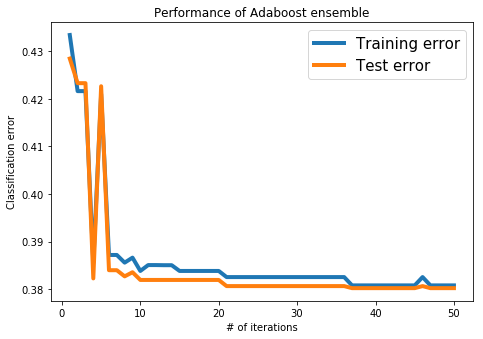

In [25]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,T), train_error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,T), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()